## easyspec tutorial 1: image cleaning

In long-slit spectroscopy, the observations are done in several steps, which include:
1) Several bias images, which are done with the shutter closed and $\sim 0$ exposure time.\
2) A few dark exposures if your camera is not refrigerated enough (i.e. < 70°C).\
3) A few ($\sim5$) flatfield images.\
4) A few ($\sim 3$) lamp spectral images for wavelength calibration.\
5) A few ($\sim3$) spectra for a standard star.\
6) Finally, a few spectra ($1\sim5$) for your target.\

In this tutorial, we will use `easyspec` `cleaning()` class to reduce, remove cosmic rays, align, and stack the observed spectra for the blazars PKSJ0049-5738 and PKSJ1118-1232 observed with SOAR. The contents are as follows: 

- trim all the images.
- master bias and debias data.
- master dark and dedark data.
- master flat, normalized master flat, and data flattening.
- remove cosmic rays
- align
- master lamp
- master target
- master standard star 

Ok, the first step you **must do** is to appropriately separate your data into distinct directories. They can look like that:

[...]/working_directory/\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$         Image_cleaning_easyspec.ipynb (i.e. this tutorial).\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$         bias/\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$       ↳ bias ".fits" files here.\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$         dark/\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$       ↳ dark ".fits" files here (if you have them).\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$         flat/\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$       ↳ flat ".fits" files here.\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$         lamp/\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$       ↳ lamp ".fits" files here.\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$         std_star/\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$       ↳ standard star ".fits" files here.\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$         spec_PKSJ0049-5738/\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$       ↳ target 1 ".fits" files here.\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$         spec_PKSJ1118-1232/\
    $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$       ↳ target 2 ".fits" files here.
    

In the scheme above, we suppose you have two targets for which you can use the same calibration files, but you can do it for as many targets as you wish.

**Note:** `easyspec` **never** modifies the original data files. These files are always safe in their original directories.
    
Now let's instantiate the `cleaning()` class:

In [49]:
import numpy as np
from easyspec.cleaning import cleaning
cleaning = cleaning()

Now we have to tell easyspec where to find the data. Note that, for the entry "targets", you can use a string (if you have only one target) or a list of strings (if you have one or more targets).

In [50]:
all_raw_data = cleaning.data_paths(bias="./bias",flats="./flat",lamp="./lamp",standard_star="./std",targets=["./spec_PKSJ0049-5738","./spec_PKSJ1118-1232"])

where `all_raw_data` is a dictionary containing the paths to the original data files (i.e. the dictionary keys) and their respective raw image data (i.e. the dictionary values). 

If the dispersion axis for your spectra are in the vertical, you must rotate your data to a horizontal dispersion axis. With the function below, we rotate all data files by a multiple of 90°. We will do it 4 times (such that we get back to the original images) just as an example:

In [51]:
all_raw_data_rotated = cleaning.rotate(all_raw_data,N_rotations=4)

So, let's take a look at the rotated data contained in the dictionary `all_raw_data_rotated`. In easyspec, you can use the function

`cleaning.plot_images(datacube=all_raw_data_rotated,image_type="all",Ncols=2,vmin=2,vmax=4.3,vertical_scale=3.5)`

to plot all the data files contained in the dictionary *all_raw_data_rotated*. However, to be more concise, let's plot only one image. Just to check if the rotation worked:

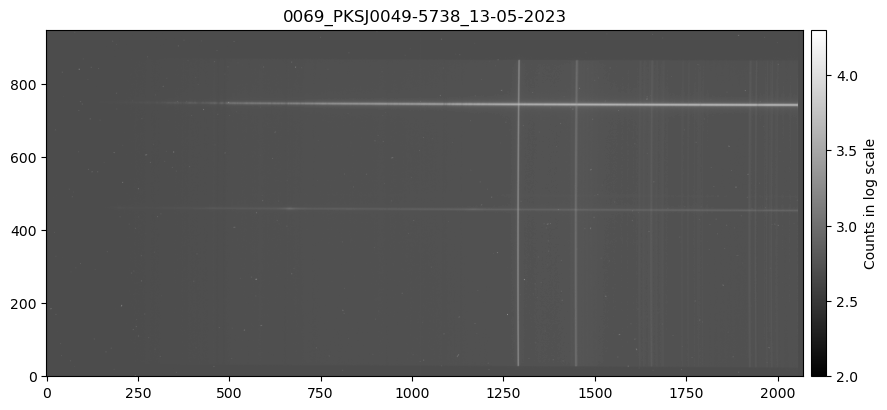

In [52]:
cleaning.plot_images(datacube=all_raw_data_rotated,image_type="target",Ncols=1,specific_image=1,vmin=2,vmax=4.3,vertical_scale=4.5)

This is one of the raw target spectra rotated $4 \times 90°$ (since the original data already had the dispersion axis in the horizontal). If you want to checkout for other data files, simple change `image_type` by "bias", "flat", "lamp", "standard_star", "target", or "dark", and play with the values in `specific_image`. If `specific_image` is not specified, all data files of a given type are plotted.

From this image, we see that the CCD borders do not contain useful data. And this is true for all data files (check it!). We have to cut off these borders and we do that with the function `trim()`:

In [53]:
trimmed = cleaning.trim(raw_image_data = all_raw_data_rotated,x1=30,x2=2050,y1=140,y2=850)

The y limits above start from the top of the image, i.e. y1 is the limit closer to the top, and y2 closer to the bottom.

Let's use the function `plot_images()` again to take a look at the trimmed images contained in the dictionary `trimmed`:

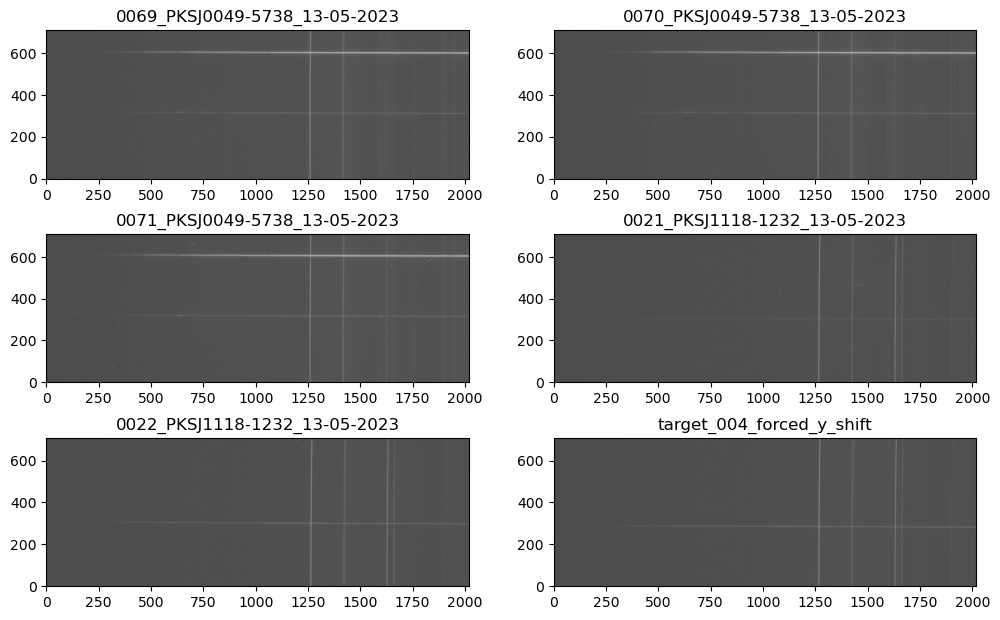

In [54]:
cleaning.plot_images(datacube=trimmed,image_type="target",Ncols=2,vmin=2,vmax=4.3,vertical_scale=2.5)

Change the `image_type` if you want to check the other images as well.

At this point we can already compute the master bias based on the trimmed images in the dictinoary `trimmed` defined above. We do that with the `easyspec` function `master()`:

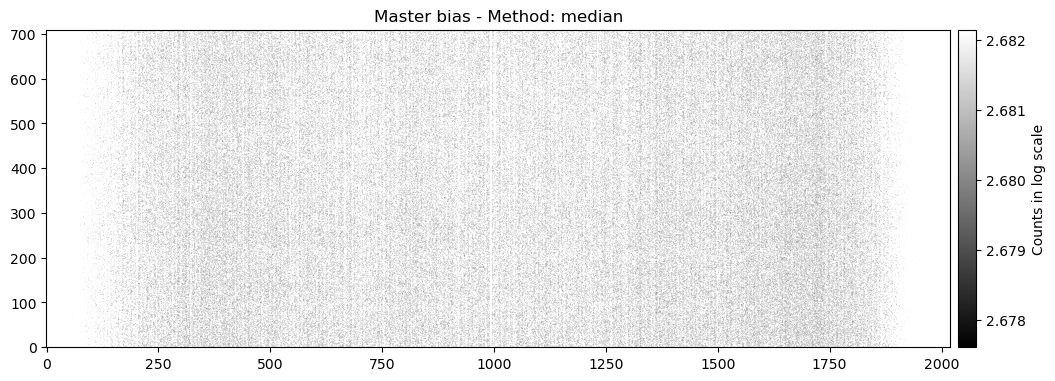

In [55]:
master_bias = cleaning.master("bias",trimmed,method="median",header_hdu_entry=1,plot=True)

where we can choose how to stack the bias images with the variable `method` accepting the options "median", "mean", or "mode". The variable `header_hdu_entry` tells easyspec where to look for the header data in the fits file extension. In our case, `header_hdu_entry = 1`, but for you it may be different. Check your data with DS9, TopCat, or astropy if you want to be sure about the choice of `header_hdu_entry`.

The function `master("bias",[...])` returns an array with the raw data for the master bias and saves a file called *master_bias.fits* in the working directory. 

Since all CCD images are biased, we have to remove the master bias from all of them. We do that with the `easyspec` function `debias()`:

In [56]:
debiased_data = cleaning.debias(trimmed,masterbias=master_bias, Type="all", pad_with_zeros=True)

which returns the dictionary `debiased_data` containing all data files debiased (excluding the bias files themselves).

**If you are using darks,** at this point you should create the master dark and subtract it from your data files, as follows:

```
master_dark = cleaning.master("dark",debiased_data,method="median",plot=True)
sub_dark_debiased_data = cleaning.sub_dark(debiased_data,masterdark=master_dark, Type="all", pad_with_zeros=True)
```

And then continue the analysis using the dictionary `sub_dark_debiased_data` instead of `debiased_data`.

Since we don't need (and don't have) darks in this tutorial, we will simply proceed with the computation of the master flat:

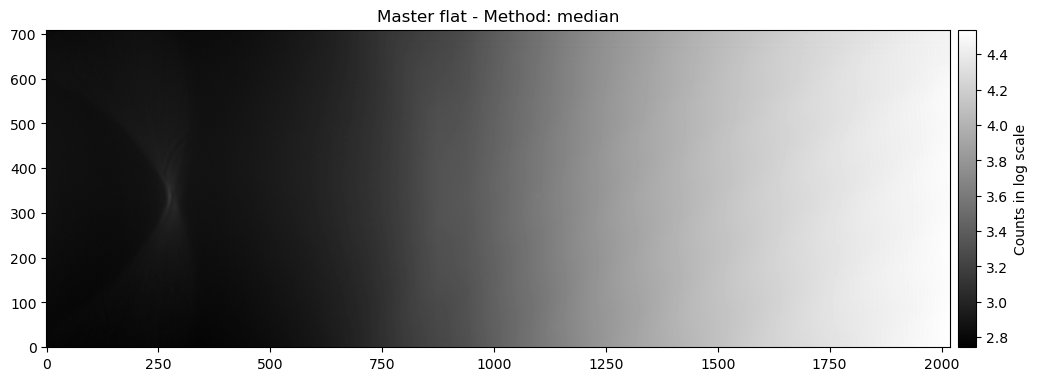

In [57]:
master_flat = cleaning.master("flat",debiased_data,method="median",header_hdu_entry=1,plot=True)

And then we normalize it by fitting a 5th degree polynomial with an orthogonal distance regression:

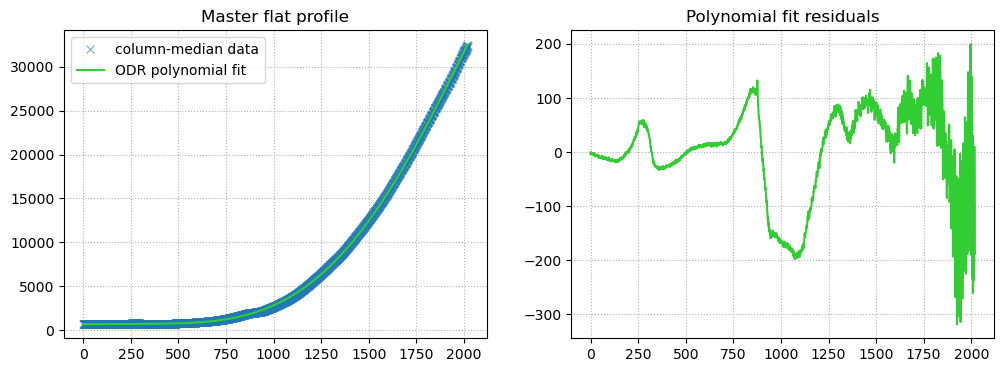

<Figure size 640x480 with 0 Axes>

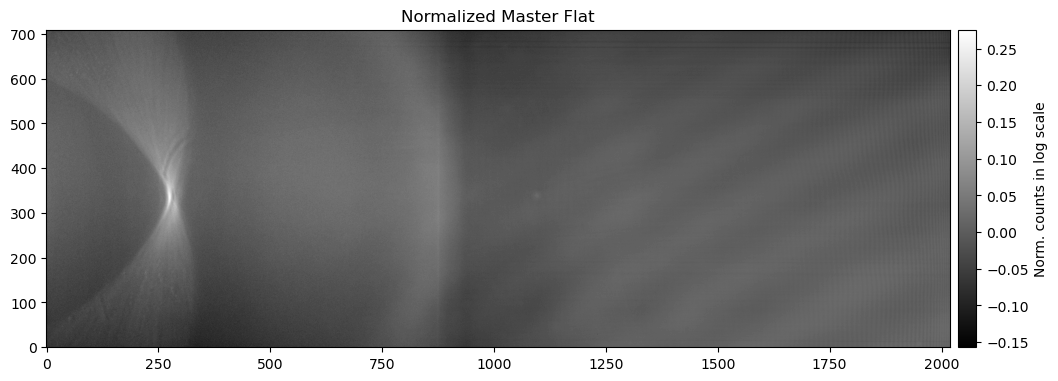

In [58]:
norm_master_flat = cleaning.norm_master_flat(master_flat,degree=5,header_hdu_entry=1,plots=True)

In the special case of SOAR, we have a lamp reflex on the left corner of the image. This may not be a big issue, but if you wish, you can mask it with the `easyspec` function `pad()`:

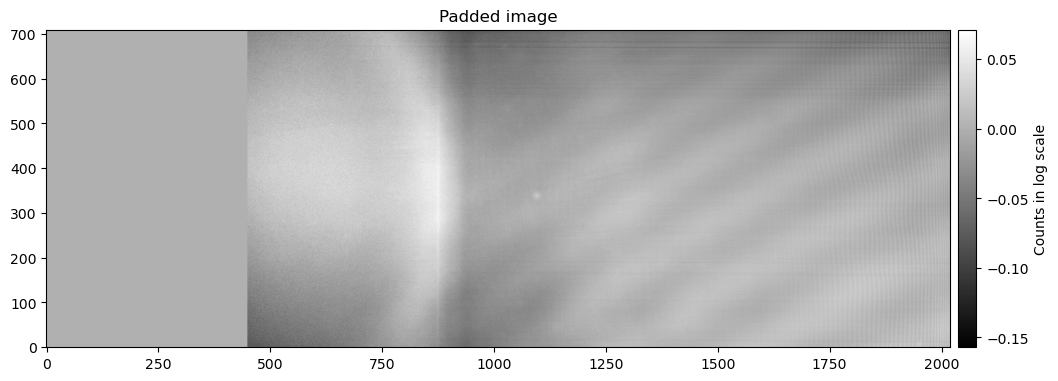

In [59]:
padded_norm_master_flat = cleaning.pad(image_data=norm_master_flat,value=1,x1=0,x2=450,y1=0,y2=710,plot=True,save_fits=True, get_header_from="./norm_master_flat.fits", fits_name="padded_image.fits", header_hdu_entry=0)

where the variable `value` takes the padding value. The variables `save_fits`, `get_header_from`, `fits_name`, and `header_hdu_entry` are needed only if you want to save a fits file with the padded image. We do it here jsut to show you how to do it, but it is really not necessary for the rest of the analysis.

The variables `master_flat`, `norm_master_flat`, and `padded_norm_master_flat` contain 2D arrays with the three different forms of the master flat raw data. Furthermore, the images `master_flat`, `norm_master_flat`, and `padded_norm_master_flat` are all saved in the working directory.

By the way, if you want to save a figure in the png, jpeg or pdf formats at any moment, you can use the function `plot()`, as shown below:

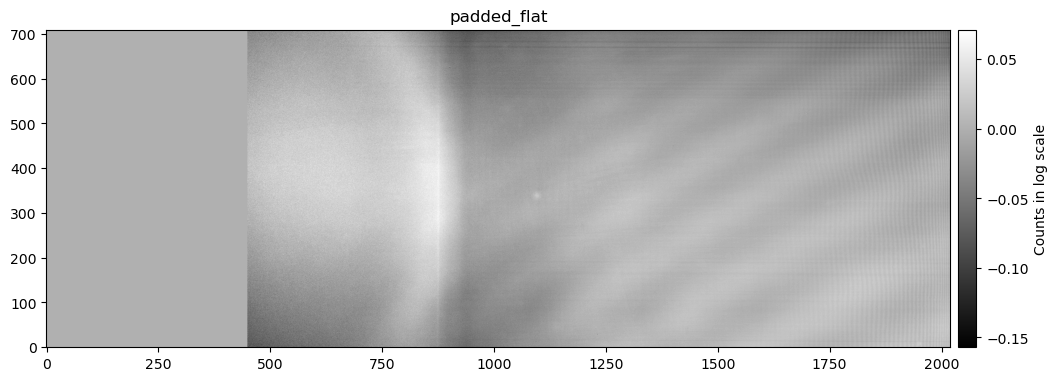

In [60]:
cleaning.plot(image_data=padded_norm_master_flat,figure_name="padded_flat",save=True,format="png")

Now that we have the normalized master flat, we can flatten our data with the fucntion `flatten()`:

In [61]:
flattened_debiased_data = cleaning.flatten(debiased_data=debiased_data,norm_master_flat=padded_norm_master_flat,Type="all")

Of course you can use the input variable `norm_master_flat` instead of `padded_norm_master_flat`, if it is the case for you. The variable `Type="all"` means that the flat field correction will be applied for all data files, except the bias and flats.

Let's take a look at the full dataset after debiasing and flattening:

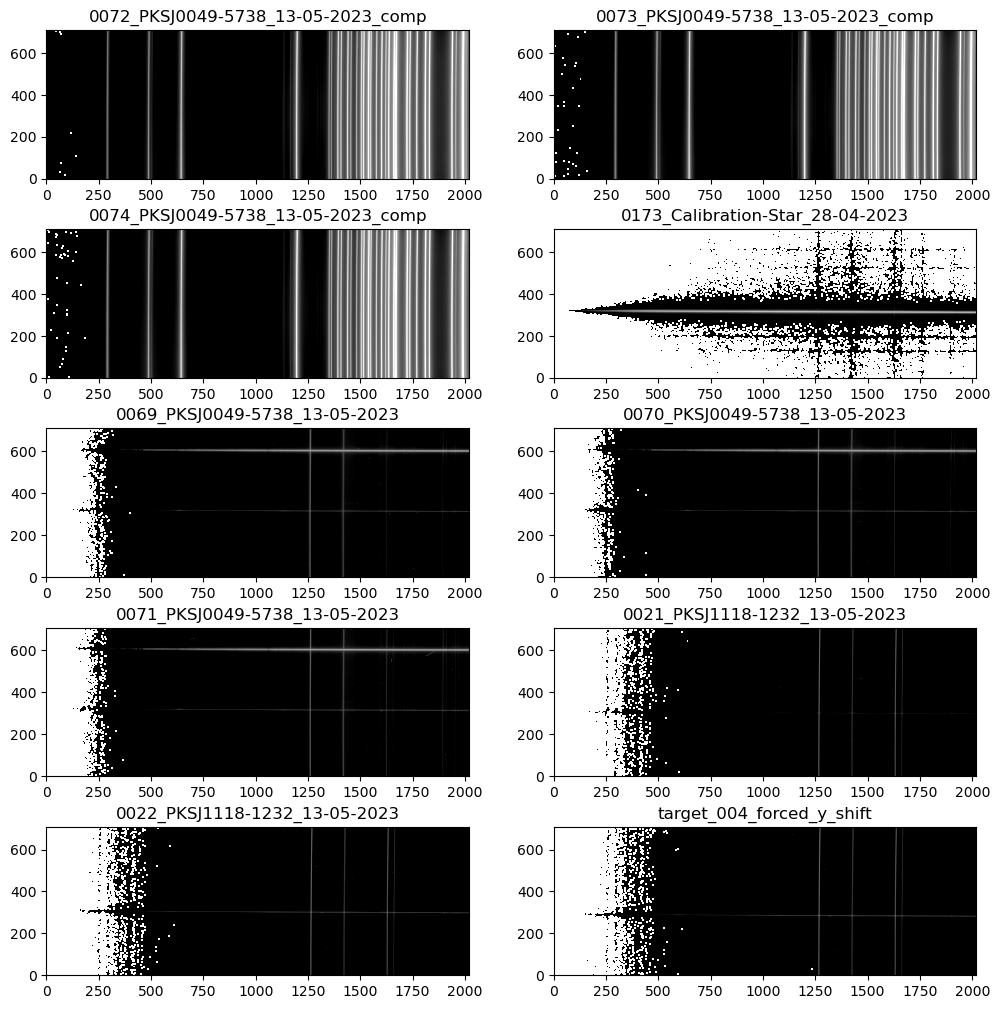

In [62]:
cleaning.plot_images(datacube=flattened_debiased_data,image_type="all",Ncols=2,vmin=2,vmax=4.3,vertical_scale=2.5)

Ok, everything looks good. The white spots appear because `matplotlib` cannot plot zero-value (or slightly negative) in log-scale, but we are good.

If at any point of the analysis you want to save the current fits files, you can use the function save_fits_files:

In [63]:
cleaning.save_fits_files(flattened_debiased_data,output_directory="./",header_hdu_entry=0,Type="target")

Here we are saving only the "target" files. This is not necessary for the rest of the analysis, but maybe you need these files to do your own checks.

At this point, we can remove the cosmic rays from our data by using the LACosmic method originally developed and implemented for IRAF by Pieter G. van Dokkum. We can do that by calling the function `CR_and_gain_corrections()`. Here we are setting:
- gain=None,gain_header_entry="GAIN" → meaning that `easyspec` will automatically look for the entry "GAIN" in the header of the original fits files. If, for isntance, you set gain = 1.54, `easyspec` will ignore the variable gain_header_entry and use 1.54 as the gain for all images.
- readnoise=None,readnoise_header_entry="RDNOISE" → the same as above.
- sigclip=7 → Laplacian-to-noise limit for cosmic ray detection. Lower values will flag more pixels as cosmic rays.

In [64]:
CR_corrected_data = cleaning.CR_and_gain_corrections(flattened_debiased_data,Type="all",gain=None,gain_header_entry="GAIN",readnoise=None,readnoise_header_entry="RDNOISE",sigclip=7)

Starting 4 L.A.Cosmic iterations
Iteration 1:
221 cosmic pixels this iteration
Iteration 2:
153 cosmic pixels this iteration
Iteration 3:
78 cosmic pixels this iteration
Iteration 4:
64 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
363 cosmic pixels this iteration
Iteration 2:
229 cosmic pixels this iteration
Iteration 3:
156 cosmic pixels this iteration
Iteration 4:
116 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
339 cosmic pixels this iteration
Iteration 2:
241 cosmic pixels this iteration
Iteration 3:
102 cosmic pixels this iteration
Iteration 4:
101 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
177 cosmic pixels this iteration
Iteration 2:
5 cosmic pixels this iteration
Iteration 3:
0 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
1229 cosmic pixels this iteration
Iteration 2:
37 cosmic pixels this iteration
Iteration 3:
4 cosmic pixels this iteration
Iteration 4:
2 

Let's compare the images before and after cosmic ray removal:

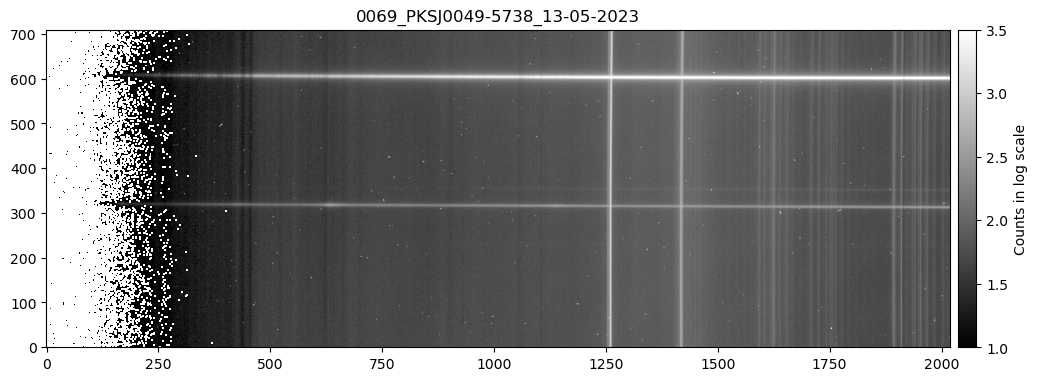

In [65]:
cleaning.plot_images(datacube=flattened_debiased_data,image_type="target",Ncols=1,specific_image=0,vmin=1,vmax=3.5,vertical_scale=4.5)

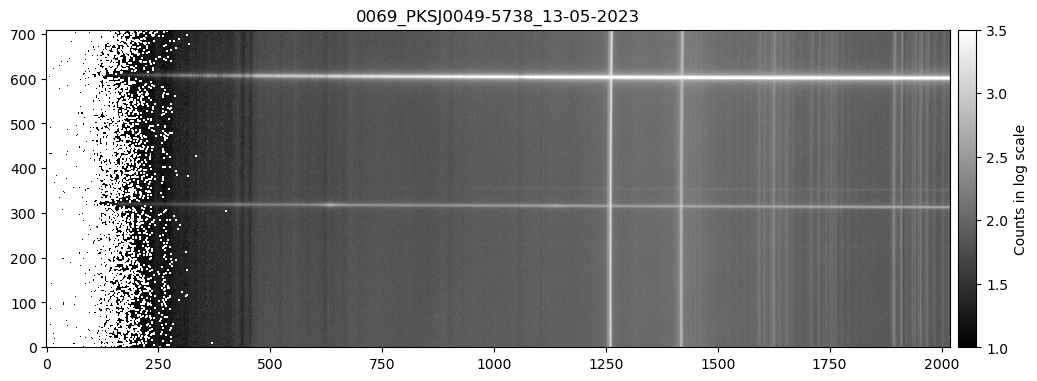

In [66]:
cleaning.plot_images(datacube=CR_corrected_data,image_type="target",Ncols=1,specific_image=0,vmin=1.0,vmax=3.5,vertical_scale=4.5)

We have a clear improvement of the image.

If we have aligned spectra, we are basically done. If this is your case, you can jump to the section **Final master files**.

If instead you have misaligned data, take a look at what can happen below. Let's generate a master target file using a "mean" instead of a "median":

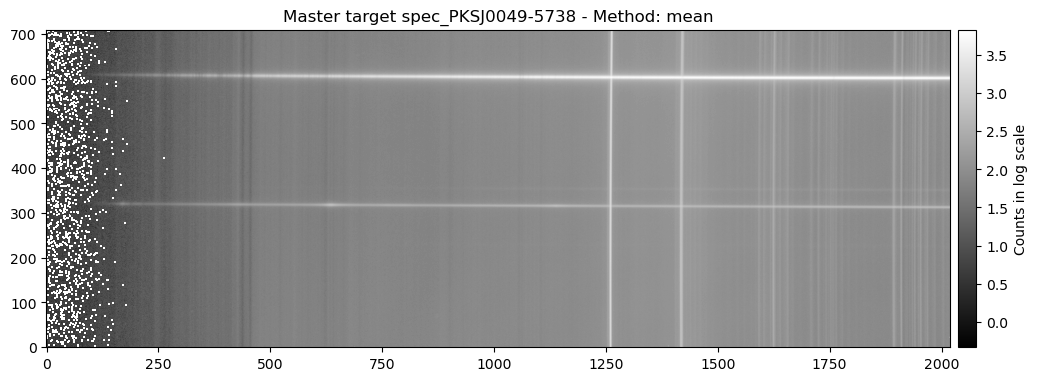

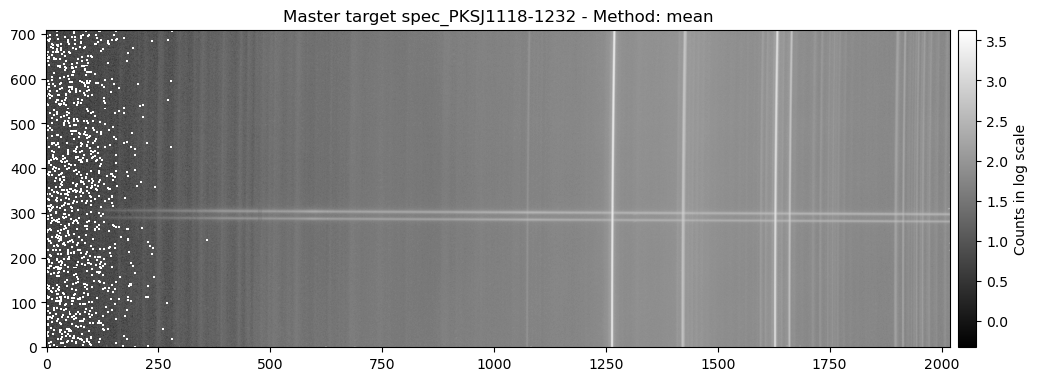

In [67]:
master_target1_desalinhado,master_target2_desalinhado = cleaning.master("target",trimmed_data=CR_corrected_data,method="mean",header_hdu_entry=1,exposure_header_entry="EXPTIME",airmass_header_entry="AIRMASS",plot=True)

We see that the stacked spectrum of PKS J1118-1232 is misaligned. The "mean" method is better to look for this kind of problem. If you have 3 or more images, the "median" method can hide these problems. Well, aligning the spectra is a quite straightforward task in `easyspec`, although it works only for **vertical alignment**. We do that by calling the `vertical_align()` function and passing the cosmic-ray corrected data:

In [68]:
aligned_data = cleaning.vertical_align(CR_corrected_data, Type="all")

Reference image:  /home/raniere/Documentos/easyspec/testes/lamp/0072_PKSJ0049-5738_13-05-2023_comp.fits.fz
Current image:  /home/raniere/Documentos/easyspec/testes/lamp/0073_PKSJ0049-5738_13-05-2023_comp.fits.fz
Vertical shift (pixels):  0
Images are already aligned in the vertical.
Current image:  /home/raniere/Documentos/easyspec/testes/lamp/0074_PKSJ0049-5738_13-05-2023_comp.fits.fz
Vertical shift (pixels):  0
Images are already aligned in the vertical.
Reference image:  /home/raniere/Documentos/easyspec/testes/std/0173_Calibration-Star_28-04-2023.fits.fz
Reference image:  /home/raniere/Documentos/easyspec/testes/spec_PKSJ0049-5738/0069_PKSJ0049-5738_13-05-2023.fits.fz
Current image:  /home/raniere/Documentos/easyspec/testes/spec_PKSJ0049-5738/0070_PKSJ0049-5738_13-05-2023.fits.fz
Vertical shift (pixels):  0
Images are already aligned in the vertical.
Current image:  /home/raniere/Documentos/easyspec/testes/spec_PKSJ0049-5738/0071_PKSJ0049-5738_13-05-2023.fits.fz
Vertical shift (pix

We see that, out of the 3 exposures we have for PKS J1118-1232, one them is shifted by one pixel with respect to the reference image, and the other is shifted by 17 pixels. The reference image here is always the first image listed in a directory, i.e. for the directory containing the original PKS J1118-1232 spectra, the reference image is: /home/raniere/Documentos/easyspec/testes/spec_PKSJ1118-1232/0021_PKSJ1118-1232_13-05-2023.fits.fz.

The final aligned images are saved in the variable aligned_data and are trimmed according to the maximum performed shift. In this case, the macimum shift was 17 pixels, as can be seen in the cell above and also in the cells below:

In [69]:
# Before alignment:
np.shape(CR_corrected_data["/home/raniere/Documentos/easyspec/testes/spec_PKSJ1118-1232/target_004_forced_y_shift.fits"])

(710, 2020)

In [70]:
# After alignment:
np.shape(aligned_data["/home/raniere/Documentos/easyspec/testes/spec_PKSJ1118-1232/target_004_forced_y_shift.fits"])

(693, 2020)

### Final master files

At this point we can create and save the main master files:

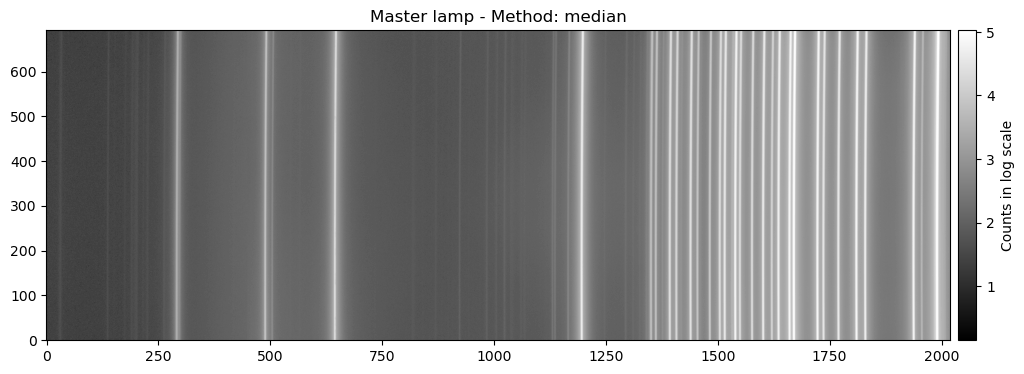

In [71]:
master_lamp = cleaning.master("lamp",aligned_data,method="median",header_hdu_entry=1,plot=True)

In the master target below, we use the "mean" just to see if the alignment was well done. 

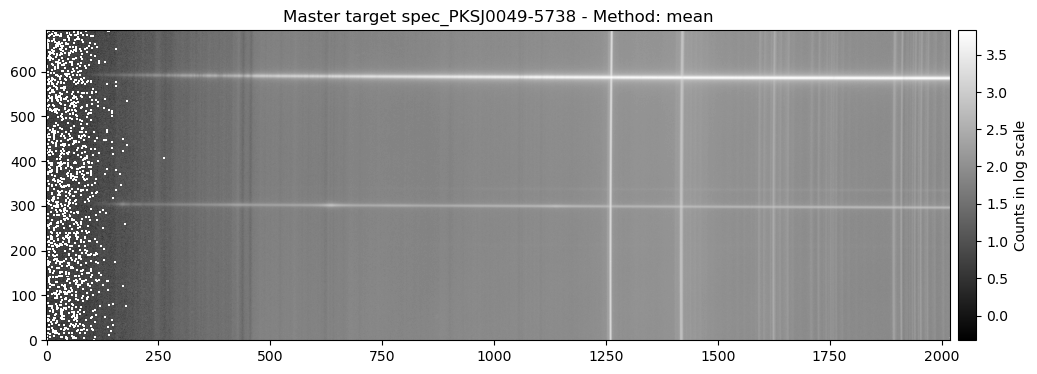

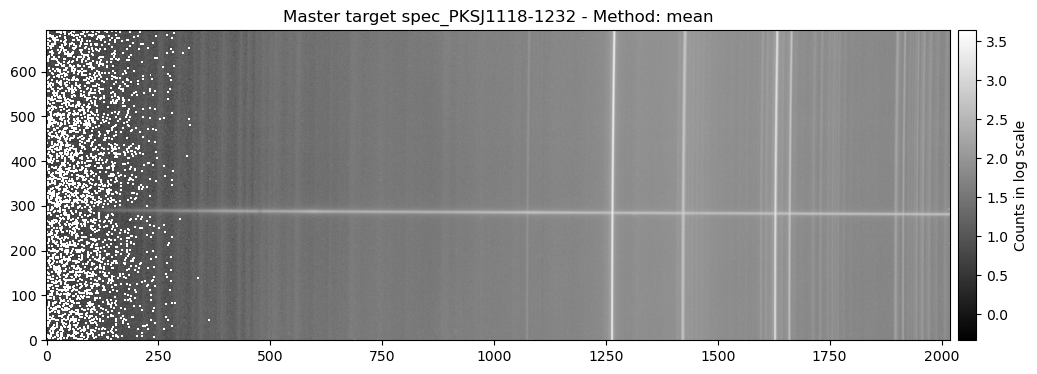

In [72]:
master_target1,master_target2 = cleaning.master("target",trimmed_data=aligned_data,method="mean",header_hdu_entry=1,exposure_header_entry="EXPTIME",airmass_header_entry="AIRMASS",plot=True)

Since the alignment looks quite good, let's compute the median master targets (in general, the median is a better choice):

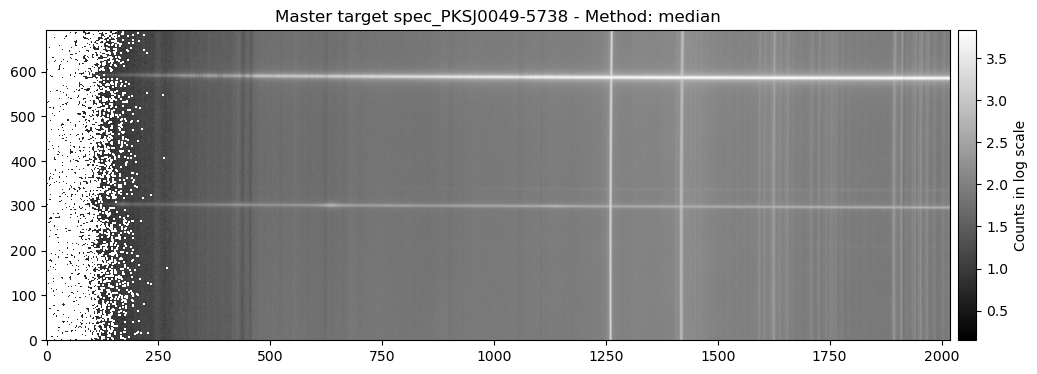

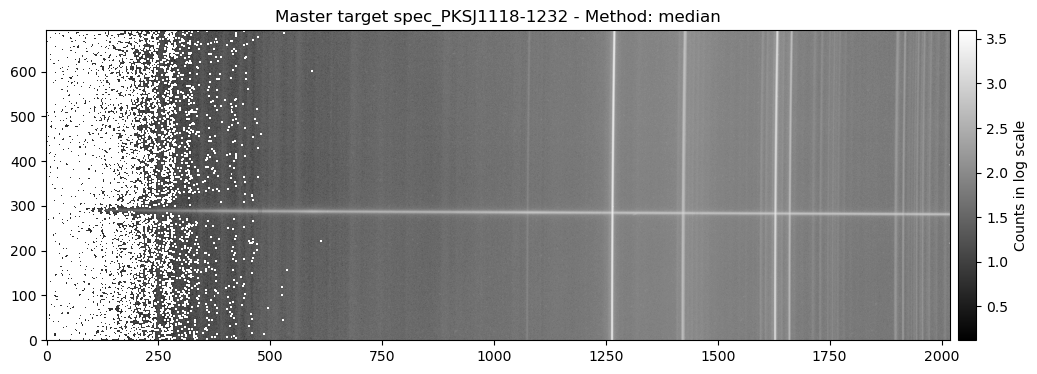

In [76]:
master_target1,master_target2 = cleaning.master("target",trimmed_data=aligned_data,method="median",header_hdu_entry=1,exposure_header_entry="EXPTIME",airmass_header_entry="AIRMASS",plot=True)

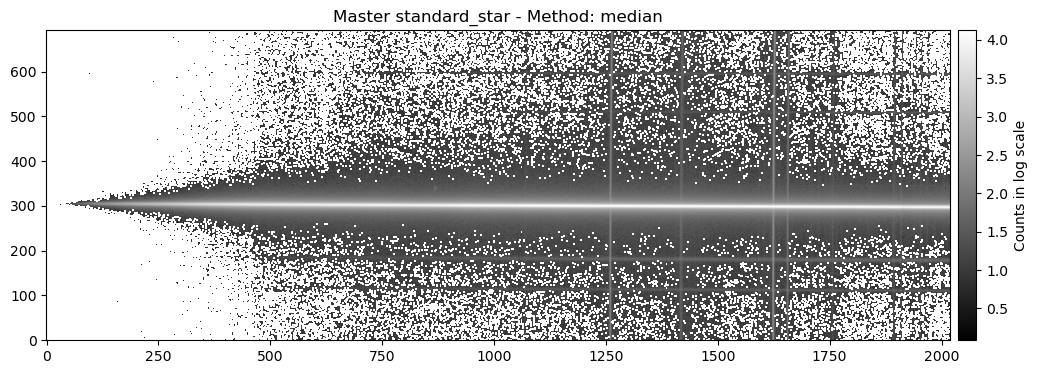

In [77]:
master_std = cleaning.master("standard_star",trimmed_data=aligned_data,method="median",header_hdu_entry=1,exposure_header_entry="EXPTIME",airmass_header_entry="AIRMASS",plot=True)

This is the image cleaning tutorial for easyspec. You can open these final images in DS9 for a better visualization. The next step is the spectral extraction with the `easyfermi` class `spec_extract()`.